In [181]:
#Import Libraries
import sys
sys.path.insert(0, "/Users/wandawang/anaconda/lib/python3.6/site-packages")
import os
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from __future__ import division
from scipy import stats
import seaborn as sns
import missingno as msno
os.chdir('/Users/wandawang/Downloads')

Problem
Using a dataset of past advertisements on the Internet, can we accurately predict what image will be an advertisement based on attributes of that image?


1) Data Preprocessing

In [182]:
#Read in the dataset - names
columns = pd.read_csv('column_names.txt', skiprows=3,sep=' |:', encoding='latin-1',
                      names=['column_name', ' ', ' '] , header = None, engine='python')


In [183]:
#Make column names into a list to reference 
cols = columns.column_name.reset_index()
result = cols[['column_name']]
colnames = result.column_name.tolist()
colnames.append('is_ad')

In [184]:
#Read in the dataset - data, pulling in column names from above
df = pd.read_csv('data', header=None, names= colnames, index_col=None, low_memory = False)

In [227]:
#df.dtypes 
#df.shape #(3279, 1559)

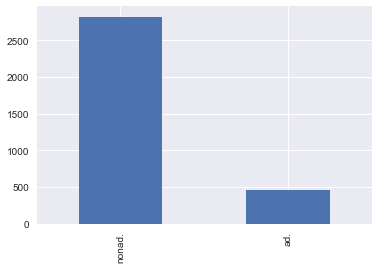

In [186]:
#Target Variable EDA. Somewhat of a class imbalance. 
df.is_ad.value_counts().plot(kind = "bar")

In [217]:
#Cleaning ? strings and target variable
df.replace(to_replace='[\s+]\?', value=-1, regex=True, inplace=True)
df.local = df.local.str.replace("?", "-1")
df.replace(to_replace='[\s*]*nonad\.', value=0.0, regex=True, inplace=True)
df.replace(to_replace='[\s*]*ad\.', value=1.0, regex=True, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce').reset_index().drop('index', axis=1)

In [221]:
target = df['is_ad']
df.drop(['is_ad'], axis=1, inplace=True)

In [222]:
target.value_counts()

0.0    2820
1.0     459
Name: is_ad, dtype: int64

In [246]:
X = df
Y = target

In [286]:
features = df.columns.tolist()

2) Data Modeling

Note: For new test sets, use above data processing tasks prior to submitting to the below modeling code

In [247]:
#Model Evaulation function 
def modeleval(X_train, X_test, Y_train, Y_test,model):
    model=model.fit(X,Y)
    print("Score: ", model.score(X, Y))
    
    print('---------Training Data Results---------')
    #print 
    predicted_train = model.predict(X_train)
    probs_train = model.predict_proba(X_train)
    print('Accuracy: ', sklearn.metrics.accuracy_score(Y_train, predicted_train))
    print('AUC: ', sklearn.metrics.roc_auc_score(Y_train, probs_train[:, 1]))
    print('Confusion Matrix: ')
    print(sklearn.metrics.confusion_matrix(Y_train, predicted_train))
    print('Classification Report: ')
    print(sklearn.metrics.classification_report(Y_train, predicted_train))
    
    print('---------Testing Data Results---------')
    #print 
    predicted_test = model.predict(X_test)
    probs_test = model.predict_proba(X_test)
    print('Accuracy: ', sklearn.metrics.accuracy_score(Y_test, predicted_test))
    print('AUC: ', sklearn.metrics.roc_auc_score(Y_test, probs_test[:, 1]))
    print('Confusion Matrix: ')
    print(sklearn.metrics.confusion_matrix(Y_test, predicted_test))
    print('Classification Report: ')
    print(sklearn.metrics.classification_report(Y_test, predicted_test))
    return model

In [248]:
#Split dataset into train and test - input df dataframe 
from sklearn.cross_validation import train_test_split
is_ad = pd.Series(target)
X_train, X_test, Y_train, Y_test = train_test_split(df,\
                                        is_ad,test_size=0.33,random_state=0) 
print('Train data set ratio: ', sum(Y_train)/float(X_train['caption*home'].count()))
print('Test data set ratio:  ', sum(Y_test)/float(X_test['caption*home'].count()))

Train data set ratio:  0.144808743169
Test data set ratio:   0.130193905817


In [249]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier(n_jobs = -1, oob_score=True) #adding oob
import sklearn.grid_search as gs

In [287]:
import warnings
warnings.filterwarnings('ignore')

In [288]:
grid_para_forest = [{"n_estimators": [10], "criterion": ["gini", "entropy"], 
                     'max_depth': [10], "min_samples_leaf": [10]}]


grid_search_forest = gs.GridSearchCV(randomForest, grid_para_forest, \
          cv=5, scoring='accuracy').fit(X_train, Y_train)
#5 fold cross validation used
print('The best score is %.4f' %grid_search_forest.best_score_)
print('The best parameters are %s' %grid_search_forest.best_params_)
print('The training error is %.4f' %(1 - grid_search_forest.best_estimator_.score(X_train, Y_train)))
print('The testing error is %.4f' %(1 - grid_search_forest.best_estimator_.score(X_test, Y_test)))

The best score is 0.9321
The best parameters are {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 10}
The training error is 0.0656
The testing error is 0.0637


In [289]:
modeleval(X_train, X_test, Y_train, Y_test,grid_search_forest)

Score:  0.941140591644
---------Training Data Results---------
Accuracy:  0.937158469945
AUC:  0.964881347077
Confusion Matrix: 
[[1877    1]
 [ 137  181]]
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96      1878
        1.0       0.99      0.57      0.72       318

avg / total       0.94      0.94      0.93      2196

---------Testing Data Results---------
Accuracy:  0.949215143121
AUC:  0.963684479981
Confusion Matrix: 
[[940   2]
 [ 53  88]]
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.95      1.00      0.97       942
        1.0       0.98      0.62      0.76       141

avg / total       0.95      0.95      0.94      1083



GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10], 'criterion': ['gini', 'entropy'], 'max_depth': [10], 'min_samples_leaf': [10]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [291]:
forest_final = grid_search_forest.best_estimator_
feature_imprtance = list(zip(X_train.columns, forest_final.feature_importances_))
dtype = [('feature', 'S30'), ('importance', 'float')]
feature_imprtance #list of tuples
feature_imprtance.sort(key=lambda tup: tup[1], reverse=True)
feature_imprtance[0:10]

[('width', 0.14690430768504992),
 ('ancurl*com', 0.072028304502034832),
 ('ancurl*click', 0.062653393652928768),
 ('alt*click+here', 0.037322128828377259),
 ('ancurl*2f', 0.036765851415326803),
 ('ancurl*type', 0.034896936946240541),
 ('ancurl*http+www', 0.032231553035424451),
 ('ancurl*redirect', 0.028835536731928409),
 ('ancurl*redirect+http', 0.028220669718703857),
 ('aratio', 0.027608706530594513)]

In [292]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier(max_features=7, n_estimators=100, 
                                 learning_rate=0.05, random_state= 2015)
gbm.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2015,
              subsample=1.0, verbose=0, warm_start=False)

In [293]:
import sklearn.metrics
print(sklearn.metrics.roc_auc_score(Y_train, gbm.predict_proba(X_train)[:,1]))
print(sklearn.metrics.roc_auc_score(Y_test, gbm.predict_proba(X_test)[:,1]))

0.971564155632
0.967591965186


In [294]:
modeleval(X_train, X_test, Y_train, Y_test,gbm)

Score:  0.92406221409
---------Training Data Results---------
Accuracy:  0.920765027322
AUC:  0.972952291009
Confusion Matrix: 
[[1878    0]
 [ 174  144]]
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.92      1.00      0.96      1878
        1.0       1.00      0.45      0.62       318

avg / total       0.93      0.92      0.91      2196

---------Testing Data Results---------
Accuracy:  0.930747922438
AUC:  0.968073813073
Confusion Matrix: 
[[940   2]
 [ 73  68]]
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.93      1.00      0.96       942
        1.0       0.97      0.48      0.64       141

avg / total       0.93      0.93      0.92      1083



GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=7, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2015,
              subsample=1.0, verbose=0, warm_start=False)

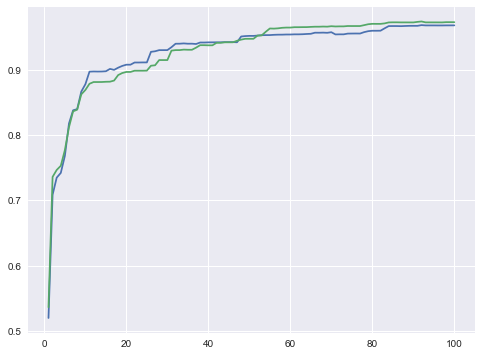

In [295]:
def plot_gbt_learning(gbt):
    test_score = np.empty(len(gbt.estimators_))
    train_score = np.empty(len(gbt.estimators_))
    for i, pred in enumerate(gbt.staged_predict_proba(X_test)):
         test_score[i] = sklearn.metrics.roc_auc_score(Y_test, pred[:,1])
    for i, pred in enumerate(gbt.staged_predict_proba(X_train)):
         train_score[i] = sklearn.metrics.roc_auc_score(Y_train, pred[:,1])
    plt.figure(figsize=(8,6))
    plt.plot(np.arange(gbt.n_estimators) + 1, test_score, label='Test') 
    plt.plot(np.arange(gbt.n_estimators) + 1, train_score, label='Train')
plot_gbt_learning(gbm)

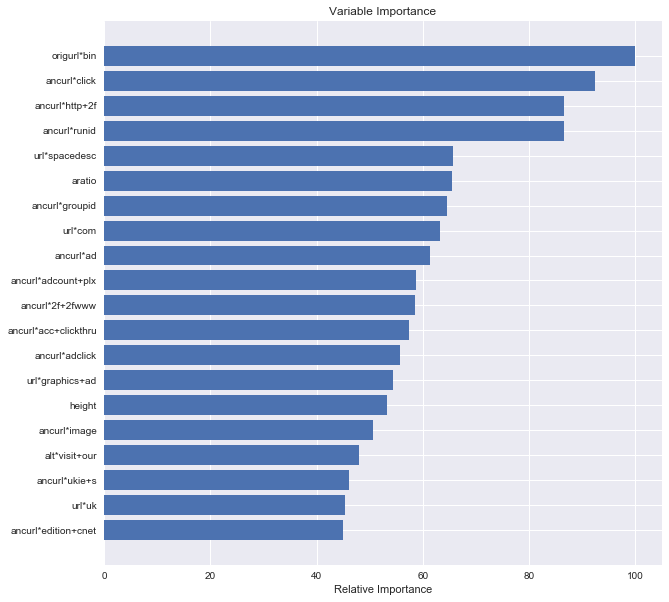

In [297]:
feature_importance = gbm.feature_importances_ 
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10, 10))
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[[sorted_idx]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

3) Analysis

Yes, we can accurately predict ad or no ad. Both and Random Forest and GBM Model were applied with varying feature importnace plots. For example, Ratio was the 10th most predictive feature for Random Forest, but was ranked 6 for GBM. 
Performance for both were both satisfactory with accuracy well above 90% for both models. 

Model Theory Discussion:
Although both random forest and gradient boosting are ensemblers, random forest decorrelates decision trees, improving upon bagging, building various decision trees on bootstrapped training samples, but splitting internal nodes in a special way.
Each time a split is considered within the construction of a decision tree, only a random subset of m of the overall p predictors are allowed to be candidates. At every split, a new subset of predictors is randomly selected.The random forest procedure forces the decision tree building process to use different predictors to split at different times. Should a good predictor be left out of consideration for some splits, it still has many chances to be considered in the construction of other splits. We can’t overfit by adding more trees! At each iteration, the classifier is being trained independently.
For GBM, the boosting procedure works in a similar way, except that the decision trees are generated in a sequential manner: Each tree is generated using information from previously grown trees; the addition of a new tree improves upon the performance of the previous trees.The trees are now dependent upon one another. Gradient Boosting builds on weak classifiers, adding one at a time so that the next one is trained to improve the already trained ensemble.